
#Paquetes


In [1]:
# prompt: mount drive and become a path as the working drectory and add to path system
import pandas as pd
from google.colab import drive
import sys
import os
import time
drive.mount('/content/drive')

path="/content/drive/My Drive/cod/RL_DS_dynamic"
os.chdir(path)
sys.path.append(path)


Mounted at /content/drive


In [2]:
!pip install --quiet stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 24.8 MB/s eta 0:00:00


In [3]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from RL_DS.envs.retailer_gym import RetailerOrdersEnv, RetailerOrdersEnv2
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from RL_DS.utils.norm2 import MinMaxWrapper2
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import time
import numpy as np

# Max scaler SAC

In [31]:
# Wrap your environment if needed (e.g., normalization)
log_dir = "./logs/sac_max_norm_log"
monitor_path=log_dir+"/monitor.csv"
env = RetailerOrdersEnv2(time_horizon=47, track_data=True)
# Optionally: env = DummyVecEnv([lambda: env])
env_sc= MinMaxWrapper2(env )


env_sc = Monitor(env_sc, filename=monitor_path, override_existing=True)
env_sc = DummyVecEnv([lambda: env_sc])  #

In [32]:
class PerEpisodeEvalCallback(BaseCallback):
    def __init__(self, save_path: str):
        super().__init__()
        self.save_path = save_path
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        # Check if the episode ended (SB3 sets 'done' flags in 'infos')

        if "episode" in self.locals["infos"][0]:  # Episode terminated
            #print(self.locals["infos"][0])
            if self.model.ep_info_buffer:
                ep_reward,*_ = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=1, deterministic=True)
                #print(evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=1, deterministic=True))
                #print(f"New best mean reward: {ep_reward:.2f}")
                if ep_reward > self.best_mean_reward:


                    self.best_mean_reward = ep_reward  # Assign ep_reward, not mean_reward
                    self.model.save(f"{self.save_path}/best_model")
        return True

In [33]:

save_path = "logs"
eval_callback = PerEpisodeEvalCallback(save_path)

model = SAC(
    policy="MlpPolicy",
    env=env_sc,
    verbose=1,
    learning_rate=1e-3,           # Faster learning
    batch_size=47,                # Smaller batches
    buffer_size=47000,           # Smaller replay buffer
    train_freq=(1,'episode'),                 # Train every step
    gradient_steps=47,             # Multiple updates per step
    learning_starts=100,          # Start updating early
    ent_coef=0.001,
    policy_kwargs={"net_arch": [64, 64]},
    seed=5# Small network for faster training
)




t1=time.time()
model.learn(total_timesteps=15000, progress_bar=True, callback=eval_callback,log_interval=10)
t2=time.time()
print("Training time (minutes):", (t2 - t1) / 60)




Output()

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47       |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 146      |
|    time_elapsed    | 3        |
|    total_timesteps | 470      |
| train/             |          |
|    actor_loss      | -0.853   |
|    critic_loss     | 0.0269   |
|    ent_coef        | 0.001    |
|    learning_rate   | 0.001    |
|    n_updates       | 329      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47       |
|    ep_rew_mean     | 24.7     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 124      |
|    time_elapsed    | 7        |
|    total_timesteps | 940      |
| train/             |          |
|    actor_loss      | -1.92    |
|    critic_loss     | 0.0203   |
|    ent_coef        | 0.001   

Training time (minutes): 2.4118524273236592


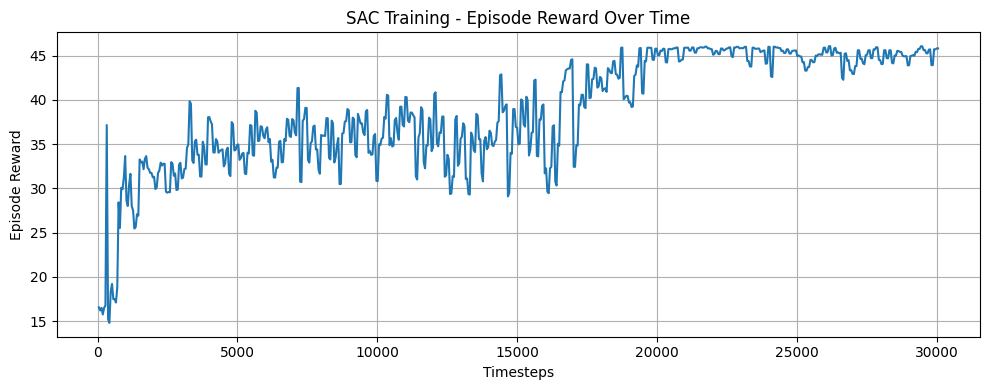

In [35]:

x, y = ts2xy(load_results(log_dir), 'timesteps')

plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("SAC Training - Episode Reward Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, *_ = test_env_sc.reset()


for step in range(47):
    action, _states = model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
#pd.DataFrame(test_env_sc.env.history)


In [37]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv('logs/actions.csv', index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)

reward:  839.3126220703125


In [38]:
mean_reward, std_reward = evaluate_policy(model,test_env_sc, n_eval_episodes=1)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 45.95 +/- 0.00


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [39]:
best_model = SAC.load("logs/best_model")
best_model.set_env(test_env_sc)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [40]:
mean_reward, std_reward = evaluate_policy(best_model,test_env_sc, n_eval_episodes=1)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 46.07 +/- 0.00


In [41]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, _ = test_env_sc.reset()

for step in range(47):
    action, _states = best_model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
#pd.DataFrame(test_env_sc.env.history)

In [42]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv('logs/actions.csv', index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)

reward:  758.110595703125
